# INM702 Coursework Task 3
### Aaron Mir (Student Number: 160001207)

The third task is about comparing your results with architectures developed using PyTorch. 

    • Compare the results obtained in Task 2 to the results obtained using the same architectures implemented in PyTorch.
    
    • Then, propose improvements and new architectures that make use of more advanced methods (e.g. Convolutional Neural Networks, dropout, ...).

    • Compare the results. 

    • Finally, present the confusion matrix of your best model.


In [102]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import transforms, datasets
import sklearn
from sklearn import metrics, preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, confusion_matrix

In [2]:
print(f"Python: {sys.version}")
print(f"Numpy Version: {np.__version__}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Sklearn Version: {sklearn.__version__}")

Python: 3.8.1 (tags/v3.8.1:1b293b6, Dec 18 2019, 23:11:46) [MSC v.1916 64 bit (AMD64)]
Numpy Version: 1.18.1
PyTorch Version: 1.6.0+cu101
Sklearn Version: 0.23.1


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
print(device)
print(torch.cuda.get_device_name(0))
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_cached())

cuda:0
GeForce GTX 1080
0
0


In [91]:
def MNIST_load(batch_size):
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_set = datasets.MNIST(root='./dataTask3', train=True, download=True, transform=trans)
    test_set = datasets.MNIST(root='./dataTask3', train=False, download=True, transform=trans)
    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)
    return train_set, test_set, train_loader, test_loader

In [92]:
train_set, test_set, train_loader, test_loader = MNIST_load(100)

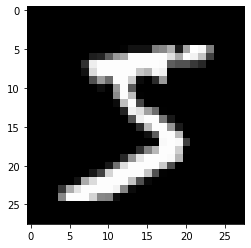

In [93]:
plt.imshow(train_set[0][0][0], cmap='gray');

In [94]:
print(len(train_loader))
print(len(test_loader))

600
100


In [95]:
for i, (images, labels) in enumerate(train_loader):           # checking to see if the data  is in the right format
    print(i, images.size(), len(labels))
    break

0 torch.Size([100, 1, 28, 28]) 100


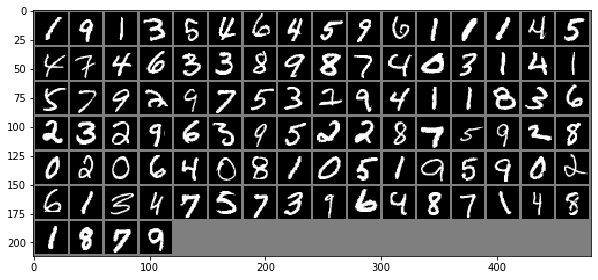

In [96]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

dataiter = iter(train_loader)                               # pulls one batch from the loader
images, labels = dataiter.next()                            # pulls out 64 images for one batch
imshow(torchvision.utils.make_grid(images, nrow=16))
images = images.to(device)
labels = labels.to(device)

In [64]:
#------------------------------------------- Main Neural Network (Fully ReLU) --------------------------------#
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.fc1 = nn.Linear(784, 64)                           # 784 inputs
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)                            # 10 outputs - 0-9
    
    def forward(self, X):
        X = X.view(-1, 784)                                     # flattens the tensor
        X = torch.relu(self.fc1(X))
        X = torch.relu(self.fc2(X))
        X = self.fc3(X)
        return X
    
    def name(self):
        return "Neural_Network"

In [65]:
model = Neural_Network().to(device)
optimiser = optim.Adam(params=model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=0.0000001)
loss_fn = nn.CrossEntropyLoss()

In [66]:
epochs = 10
history_loss = []
for epoch in range(epochs):
    train_loss = [] 
    model.train()
    for batch_idx, (X, y) in enumerate(train_loader):      #for each batch of images
        #------------Moving to device---------#
        X = X.to(device)  
        y = y.to(device)  
        #------------Forward Pass---------#
        optimiser.zero_grad()    
        y_pred = model(X) 
        loss = loss_fn(y_pred, y)
        #------------Backward Pass---------#
        loss.backward()
        optimiser.step()
        train_loss.append(loss.item())
    loss_now = np.mean(train_loss)
    history_loss.append(loss_now)
    print(f'epoch: {epoch}, train loss: {loss_now:.6f}')

epoch: 0, train loss: 0.463908
epoch: 1, train loss: 0.243501
epoch: 2, train loss: 0.183421
epoch: 3, train loss: 0.151858
epoch: 4, train loss: 0.129561
epoch: 5, train loss: 0.112456
epoch: 6, train loss: 0.103292
epoch: 7, train loss: 0.092948
epoch: 8, train loss: 0.085764
epoch: 9, train loss: 0.078766


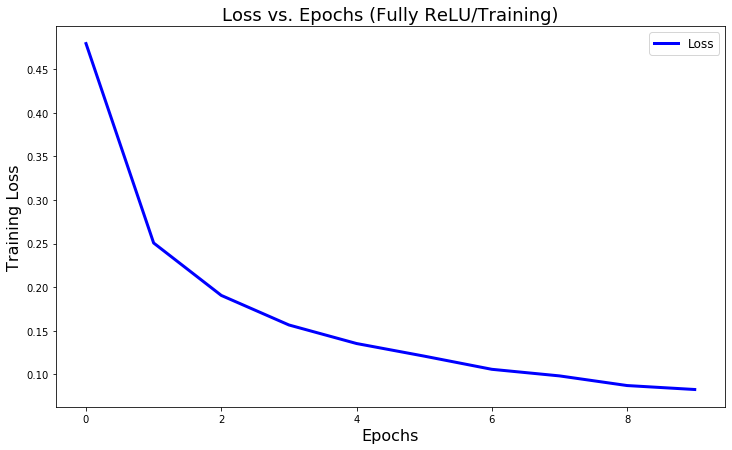

In [67]:
plt.figure(figsize=(12, 7))
plt.plot(history, 'b', linewidth=3.0, label='Loss')
plt.title('Loss vs. Epochs (Fully ReLU/Training)', fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training Loss', fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [73]:
''' DEFINING CONFUSION MATRIX PLOT FUNCTION TAKEN FROM SKLEARN WEBSITE'''
def plot_confusion_matrix(cm, classes, 
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1100    0    0    0    0    0    0    0    0    0]
 [   0 1200    0    0    0    0    0    0    0    0]
 [   0    0  800  100    0    0    0    0    0    0]
 [   0    0  100  800    0    0    0    0  100    0]
 [   0    0    0    0 1200    0    0    0    0    0]
 [   0    0    0    0    0  500  100    0    0    0]
 [   0    0    0    0    0    0 1200    0    0    0]
 [   0    0    0    0    0    0    0 1100    0    0]
 [   0    0    0    0    0    0    0    0 1000    0]
 [   0    0    0    0    0    0    0    0    0  700]]
[100.         100.          88.88888889  80.         100.
  83.33333333 100.         100.         100.         100.        ]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      1100
           1      1.000     1.000     1.000      1200
           2      0.889     0.889     0.889       900
           3      0.889     0.800     0.842      1000
           4      1.000     1.000

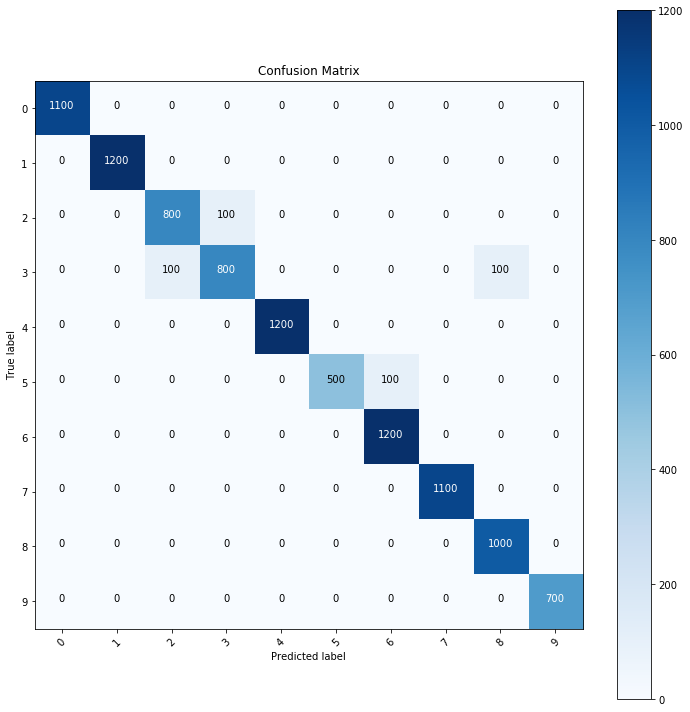

In [74]:
nb_classes = 9
# Initialize the prediction and label lists(tensors)
pred_list=torch.zeros(0,dtype=torch.long, device='cpu')
label_list=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    model2.eval()
    for i, (X, y) in enumerate(test_loader):
        X = X.to(device)
        y = y.to(device)
        y_pred = model(inputs)
        _, preds = torch.max(y_pred, 1)
        # Append batch prediction results
        pred_list=torch.cat([pred_list,preds.view(-1).cpu()])
        label_list=torch.cat([label_list,classes.view(-1).cpu()])
# Confusion matrix
cm=confusion_matrix(label_list.numpy(), pred_list.numpy())
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')
# Per-class accuracy
class_accuracy=100*cm.diagonal()/cm.sum(1)
print(class_accuracy)
print(classification_report(label_list.numpy(), pred_list.numpy(), digits=3))

In [79]:
#------------------------------------------- Main Neural Network (Fully ReLU) --------------------------------#
class Neural_Network2(nn.Module):
    def __init__(self):
        super(Neural_Network2, self).__init__()
        self.fc1 = nn.Linear(784, 64)                           # 784 inputs
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)                            # 10 outputs - 0-9
    
    def forward(self, X):
        X = X.view(-1, 784)                                     # flattens the tensor
        X = torch.sigmoid(self.fc1(X))
        X = torch.sigmoid(self.fc2(X))
        X = self.fc3(X)
        return X
    
    def name(self):
        return "Neural_Network2"

In [80]:
model2 = Neural_Network2().to(device)
optimiser = optim.Adam(model2.parameters(), lr=0.01, betas=(0.9, 0.999), eps=0.0000001)
loss_fn = nn.CrossEntropyLoss()

In [81]:
epochs = 10
history_loss = []
for epoch in range(epochs):
    train_loss = [] 
    model2.train()
    for batch_idx, (X, y) in enumerate(train_loader):      #for each batch of images
        #------------Moving to device---------#
        X = X.to(device)  
        y = y.to(device)  
        #------------Forward Pass---------#
        optimiser.zero_grad()    
        y_pred = model2(X) # X.view(-1, 784)
        loss = loss_fn(y_pred, y)
        #------------Backward Pass---------#
        loss.backward()
        optimiser.step()
        train_loss.append(loss.item())
    loss_now = np.mean(train_loss)
    history_loss.append(loss_now)
    print(f'epoch: {epoch}, train loss: {loss_now:.6f}')

epoch: 0, train loss: 0.665620
epoch: 1, train loss: 0.376172
epoch: 2, train loss: 0.338157
epoch: 3, train loss: 0.317419
epoch: 4, train loss: 0.309226
epoch: 5, train loss: 0.295415
epoch: 6, train loss: 0.289931
epoch: 7, train loss: 0.286521
epoch: 8, train loss: 0.270480
epoch: 9, train loss: 0.266081


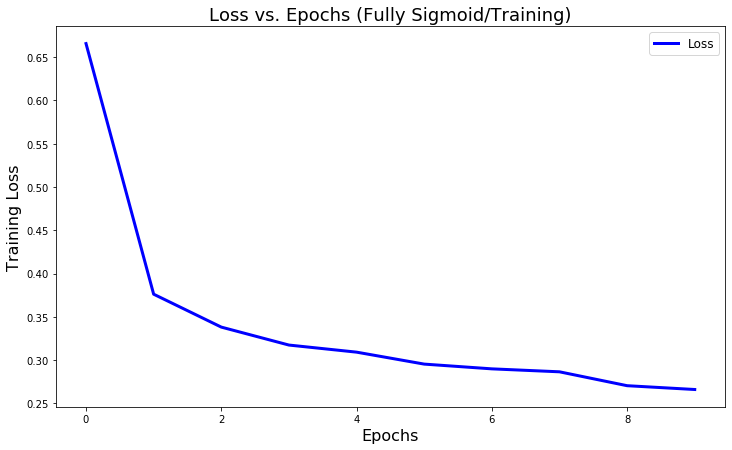

In [84]:
plt.figure(figsize=(12, 7))
plt.plot(history_loss, 'b', linewidth=3.0, label='Loss')
plt.title('Loss vs. Epochs (Fully Sigmoid/Training)', fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training Loss', fontsize=16)
plt.legend(fontsize=12)
plt.show()

Confusion matrix, without normalization
[[1100    0    0    0    0    0    0    0    0    0]
 [   0 1200    0    0    0    0    0    0    0    0]
 [   0    0  900    0    0    0    0    0    0    0]
 [   0    0    0  800    0    0    0    0    0  200]
 [   0    0    0    0 1200    0    0    0    0    0]
 [   0    0  100  100    0  300  100    0    0    0]
 [   0    0    0    0    0    0 1200    0    0    0]
 [   0    0    0    0    0    0    0 1100    0    0]
 [   0  100    0    0    0    0    0    0  900    0]
 [   0    0    0    0    0    0    0    0    0  700]]
[100. 100. 100.  80. 100.  50. 100. 100.  90. 100.]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      1100
           1      0.923     1.000     0.960      1200
           2      0.900     1.000     0.947       900
           3      0.889     0.800     0.842      1000
           4      1.000     1.000     1.000      1200
           5      1.000     0.500     0.667       60

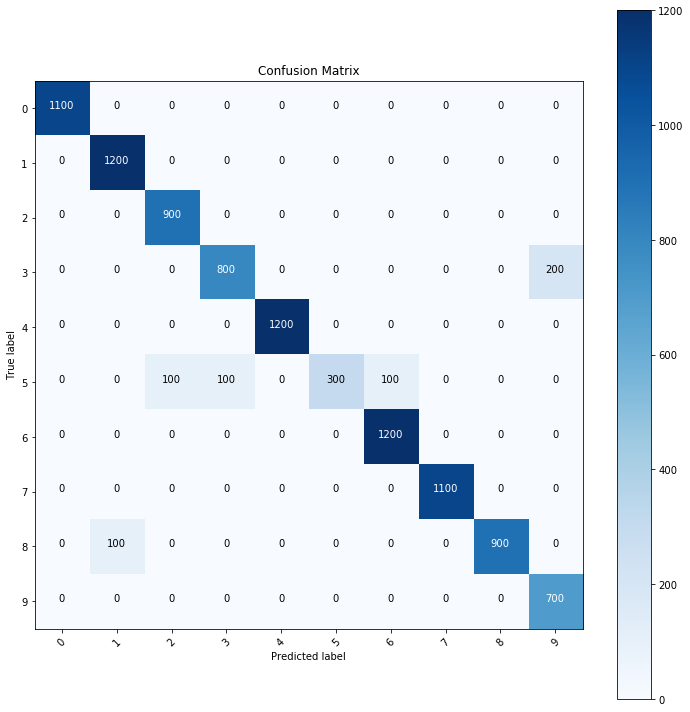

In [83]:
nb_classes = 9
# Initialize the prediction and label lists(tensors)
pred_list = torch.zeros(0,dtype=torch.long, device='cpu')
label_list = torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    model2.eval()
    for i, (X, y) in enumerate(test_loader):
        X = X.to(device)
        y = y.to(device)
        y_pred = model2(inputs)
        _, preds = torch.max(y_pred, 1)
        # Append batch prediction results
        pred_list=torch.cat([pred_list,preds.view(-1).cpu()])
        label_list=torch.cat([label_list,classes.view(-1).cpu()])
# Confusion matrix
cm=confusion_matrix(label_list.numpy(), pred_list.numpy())
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')
# Per-class accuracy
class_accuracy=100*cm.diagonal()/cm.sum(1)
print(class_accuracy)
print(classification_report(label_list.numpy(), pred_list.numpy(), digits=3))

In [113]:
train_set, test_set, train_loader, test_loader = MNIST_load(64)

In [114]:
for i, (images, labels) in enumerate(train_loader):           # checking to see if the data  is in the right format
    print(i, images.size(), len(labels))
    break

0 torch.Size([64, 1, 28, 28]) 64


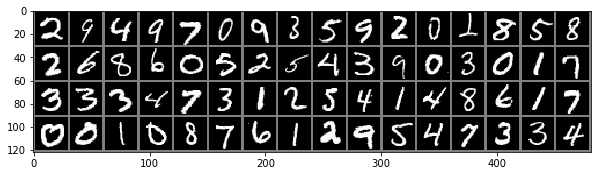

In [115]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

dataiter = iter(train_loader)                               # pulls one batch from the loader
images, labels = dataiter.next()                            # pulls out 64 images for one batch
imshow(torchvision.utils.make_grid(images, nrow=16))
images = images.to(device)
labels = labels.to(device)

In [274]:
#------------------------------------------- Main Neural Network (CNN) --------------------------------#
class Neural_Network3(nn.Module):
    def __init__(self):
        super(Neural_Network3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, 3) 
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(64*6*6,600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)
        
    def forward(self, X):
        X = self.pool1(F.relu(self.bn1(self.conv1(X))))
        X = self.pool2(F.relu(self.bn2(self.conv2(X))))
        X = X.view(-1, 64*6*6)
        X = self.fc1(X)
        X = self.drop(X)
        X = self.fc2(X)
        X = self.fc3(X)   
        return F.log_softmax(X, dim=1)
    
    def name(self):
        return "Neural_Network3"

In [275]:
model3 = Neural_Network3().to(device)
optimiser = optim.Adam(model3.parameters(), lr=0.001, betas=(0.9, 0.999), eps=0.0000001)
loss_fn = nn.CrossEntropyLoss()

In [276]:
epochs = 8
history_loss = []
for epoch in range(epochs):
    train_loss = [] 
    model3.train()
    for batch_idx, (X, y) in enumerate(train_loader):      # for each batch of images
        #------------Moving to device---------#
        X = X.to(device)  
        y = y.to(device)  
        #------------Forward Pass---------#
        optimiser.zero_grad()    
        y_pred = model3(X) 
        loss = loss_fn(y_pred, y)
        #------------Backward Pass---------#
        loss.backward()
        optimiser.step()
        train_loss.append(loss.item())
    loss_now = np.mean(train_loss)
    history_loss.append(loss_now)
    print(f'epoch: {epoch}, train loss: {loss_now:.6f}')

epoch: 0, train loss: 0.167953
epoch: 1, train loss: 0.070854
epoch: 2, train loss: 0.056546
epoch: 3, train loss: 0.049577
epoch: 4, train loss: 0.037724
epoch: 5, train loss: 0.033076
epoch: 6, train loss: 0.029896
epoch: 7, train loss: 0.023590
epoch: 8, train loss: 0.025005
epoch: 9, train loss: 0.020144


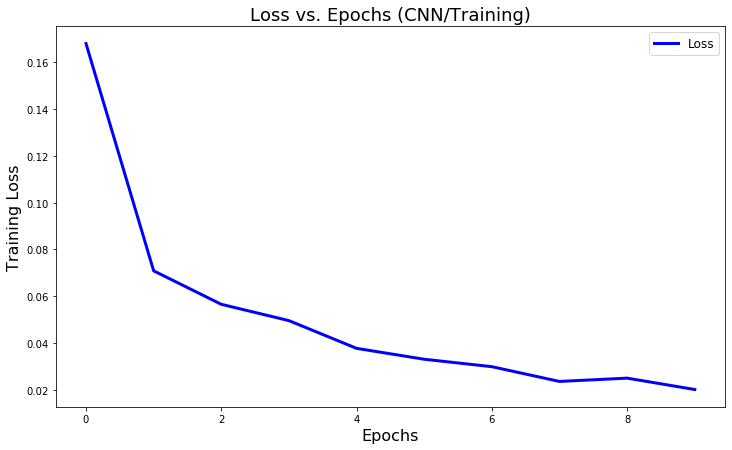

In [277]:
plt.figure(figsize=(12, 7))
plt.plot(history_loss, 'b', linewidth=3.0, label='Loss')
plt.title('Loss vs. Epochs (CNN/Training)', fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training Loss', fontsize=16)
plt.legend(fontsize=12)
plt.show()

Confusion matrix, without normalization
[[1727    0    0    0    0    0    0    0    0    0]
 [   0 1884    0    0    0    0    0    0    0    0]
 [   0    0 1413    0    0    0    0    0    0    0]
 [   0    0    0 1570    0    0    0    0    0    0]
 [   0    0    0    0 1884    0    0    0    0    0]
 [   0    0    0    0    0  942    0    0    0    0]
 [   0    0    0    0    0    0 1884    0    0    0]
 [   0    0    0    0    0    0    0 1727    0    0]
 [   0    0    0    0    0    0    0    0 1570    0]
 [   0    0    0    0    0    0    0    0    0 1099]]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      1727
           1      1.000     1.000     1.000      1884
           2      1.000     1.000     1.000      1413
           3      1.000     1.000     1.000      1570
           4      1.000     1.000     1.000      1884
           5      1.000     1.000     1.000       94

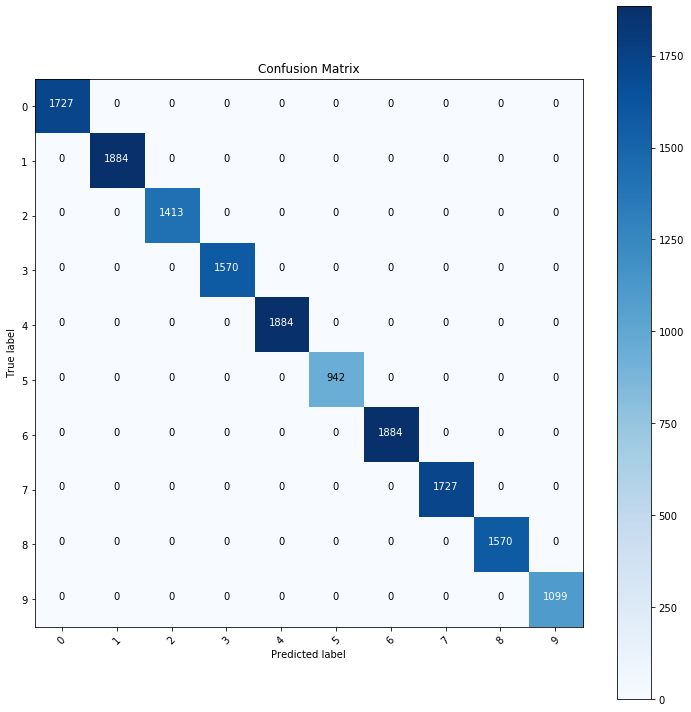

In [278]:
nb_classes = 9
# Initialize the prediction and label lists(tensors)
pred_list = torch.zeros(0,dtype=torch.long, device='cpu')
label_list = torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    model3.eval()
    for i, (X, y) in enumerate(test_loader):
        X = X.to(device)
        y = y.to(device)
        y_pred = model3(inputs)
        _, preds = torch.max(y_pred, 1)
        # Append batch prediction results
        pred_list=torch.cat([pred_list,preds.view(-1).cpu()])
        label_list=torch.cat([label_list,classes.view(-1).cpu()])
# Confusion matrix
cm=confusion_matrix(label_list.numpy(), pred_list.numpy())
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')
# Per-class accuracy
class_accuracy = 100 * cm.diagonal()/cm.sum(1)
print(class_accuracy)
print(classification_report(label_list.numpy(), pred_list.numpy(), digits=3))